In [2]:

from probability_trees import PTree
from itertools import combinations

def simple_var(name, prob):
     return [(prob, f"{name}=1"), (1-prob, f"{name}=0")]


def leaky_or(parents_prob, child, bvars, leak):
    result = []
    active_parents = [p for p in parents_prob.keys() if bvars[p]=="1"]
    for l in range(len(active_parents)+1):
        for c in combinations(active_parents, l):
            gprob = 1
            pvars = []
            for parent in active_parents:
                prob = parents_prob[parent]
                if parent in c:
                    pvars.append(f"U_{parent}_{child}=1")
                    gprob *= prob
                else:
                    pvars.append(f"U_{parent}_{child}=0")
                    gprob *= (1-prob)
            if l:
                result.append((gprob, ",".join(pvars+[f"{child}=1"])))
            else:
                result.append((gprob * leak,
                               ",".join(pvars+[f"L_{child}=1,{child}=1"])))
                result.append((gprob * (1-leak),
                               ",".join(pvars+[f"L_{child}=0,{child}=0"])))
    return result

def asia_model( bvar ):
     if 'Bronchitis' not in bvar:
        return simple_var("Bronchitis", 0.2)
     if 'LungCancer' not in bvar:
        return simple_var("LungCancer", 0.07)
     if 'Dyspnea' not in bvar:
        return leaky_or({"LungCancer": 0.3, 
                         "Bronchitis": 0.1},
                        "Dyspnea", bvar, 0.3)
     if 'Xray' not in bvar:
        return leaky_or({"LungCancer": 0.3}, "Xray", bvar, 0.03)
     return None


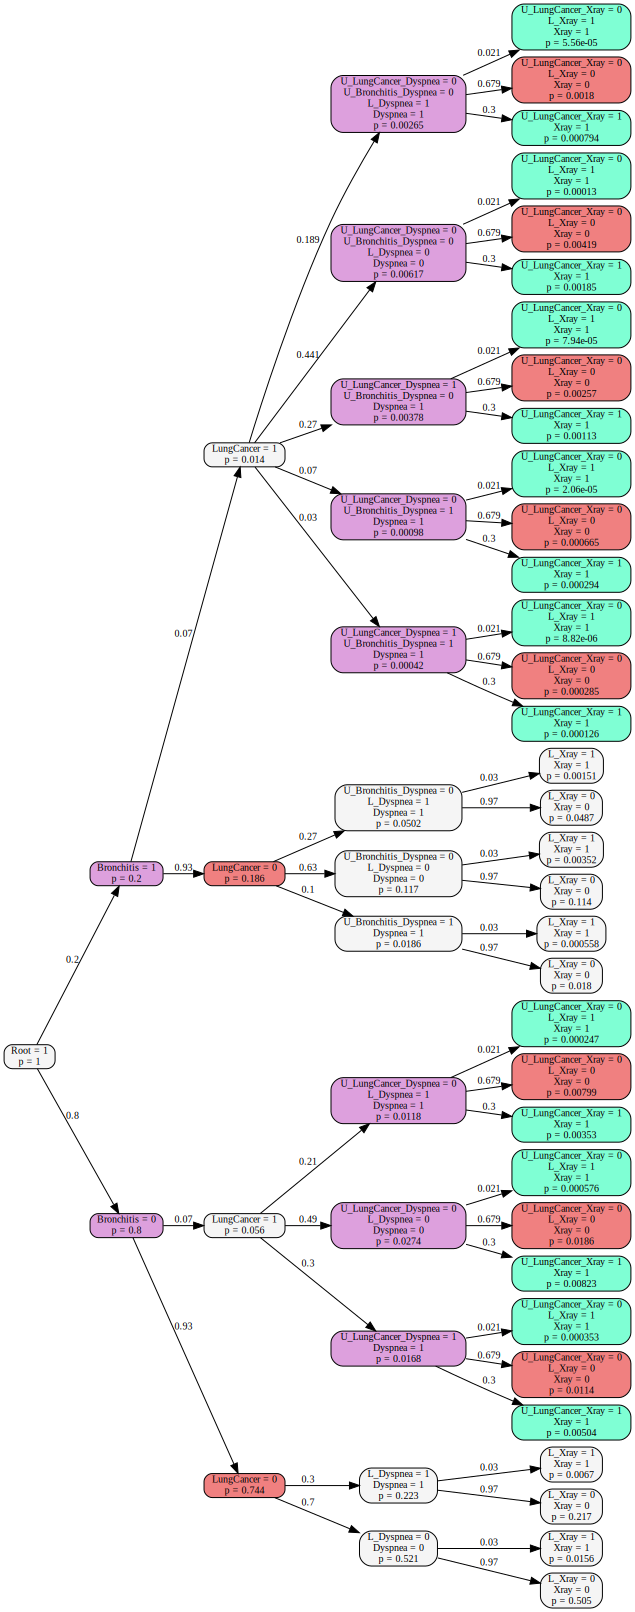

0.022470000000000004

In [3]:
asia = PTree.fromFunc(asia_model, 'Root=1')
xray_and_lung_cancer = asia.prop('Xray=1') & asia.prop('LungCancer=1')

display(asia.show(show_prob=True, cut=xray_and_lung_cancer, crit=asia.critical(xray_and_lung_cancer)))
asia.prob(xray_and_lung_cancer)

In [26]:
def asia_model( bvar ):
    p_bronchitis = 0.2
    p_lung_cancer = 0.07
    u_bronchitis_dyspnea = 0.1
    u_lung_cancer_dyspnea = 0.3
    u_lung_cancer_xray = 0.3
    l_xray = 0.03
    l_dyspnea = 0.3
    
    if 'Bronchitis' not in bvar:
        return bronchitis_is_exogenous( p_bronchitis, u_bronchitis_dyspnea )
    if 'LungCancer' not in bvar:
        return lung_cancer_is_exogenous( p_lung_cancer, u_lung_cancer_dyspnea, u_lung_cancer_xray )
    if 'Dyspnea' not in bvar:
        return dyspnea_if_lung_cancer_or_bronchitis( bvar['LungCancer'], bvar['U_lung_cancer_dyspnea'],
                                                     bvar['Bronchitis'], bvar['U_bronchitis_dyspnea'],
                                                     l_dyspnea
                                                   )
    if 'Xray' not in bvar:
        return xray_if_lung_cancer( bvar['LungCancer'], bvar['U_lung_cancer_xray'], l_xray )
    return None

In [17]:
def bronchitis_is_exogenous( p, q):
    return [( (1-p), 'U_bronchitis_dyspnea=0,Bronchitis=0'),
             (p*(1-q) , 'U_bronchitis_dyspnea=0,Bronchitis=1'),
             (p*q, 'U_bronchitis_dyspnea=1,Bronchitis=1')]

In [25]:
def lung_cancer_is_exogenous( p, q, r):
    return [( (1-p)         , 'LungCancer=0,U_lung_cancer_dyspnea=0,U_lung_cancer_xray=0'),
             (p*(1-q)*(1-r) , 'LungCancer=1,U_lung_cancer_dyspnea=0,U_lung_cancer_xray=0'),
            (p*(1-q)*r      , 'LungCancer=1,U_lung_cancer_dyspnea=0,U_lung_cancer_xray=1'),
            (p*q*(1-r)      , 'LungCancer=1,U_lung_cancer_dyspnea=1,U_lung_cancer_xray=0'),
            (p*q*r          ,  'LungCancer=1,U_lung_cancer_dyspnea=1,U_lung_cancer_xray=1')
             ]

In [28]:
def dyspnea_if_lung_cancer_or_bronchitis(lung_cancer, u_l, bronchitis, u_b, leak):
    if (lung_cancer == '1' and u_l == '1') or (bronchitis == '1' and u_b == '1'):
        return [(1, 'Dyspnea=1'),
                (0, 'Dyspnea=0')]
    else:
        return [(leak, 'Dyspnea=1'),
                (1-leak, 'Dyspnea=0')]

In [22]:
             

def xray_if_lung_cancer(lung_cancer, u_l, leak):
    if (lung_cancer == '1' and u_l == '1'):
        return [(1, 'Xray=1'),
                (0, 'Xray=0')]
    else:
        return [(leak, 'Xray=1'),
                (1-leak, 'Xray=0')]

In [ ]:
def 